# Use case 1: Detection. Kimberlina 1.2 models

### 1. User defines site settings, objectives and criteria.

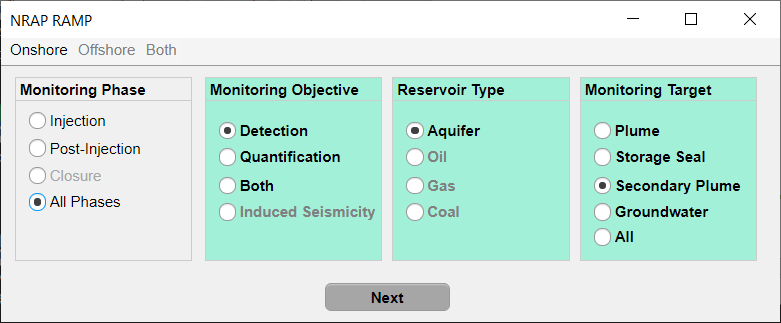

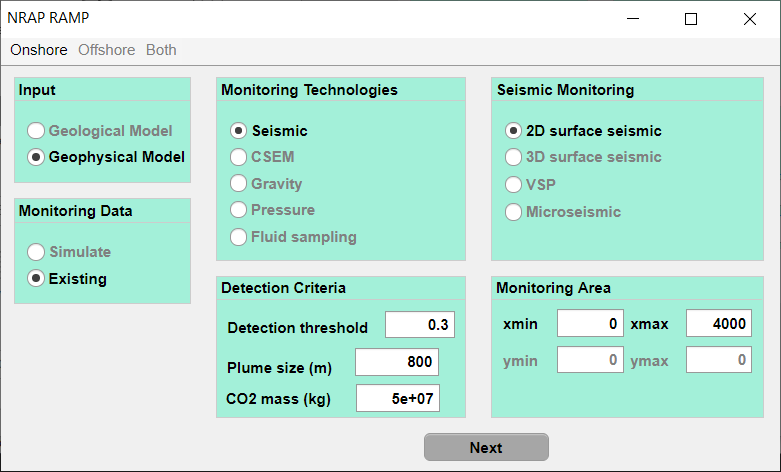

### 2. Setup of the spatial and temporal data for the workflow

In [1]:
# Import required Python packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
 %matplotlib inline

In [3]:
# Temporal data
time_points = 10*np.arange(1, 21)
num_time_points = len(time_points)

# Scenario data
excluded = [37, 118, 136, 150, 182, 245] # 6 scenarios
scenarios = list(set(range(1, 307)).difference(excluded))
num_scenarios = len(scenarios)

# Domain coordinates
coordinates = {1: 4000 + 10*np.arange(401),
               2: 10*np.arange(141)}  # 1 is x, 2 is z

### 3. Input: Geological models (velocity models) are loaded

In [4]:
# Setup directories
data_directory = 'data'
output_directory = 'output'

In [5]:
# Load velocity data
velocity_data_file = os.path.join(data_directory, 'velocity_data_50_scenarios.npz')
velocity = np.load(velocity_data_file)['data']
print('Velocity data shape:', velocity.shape)

Velocity data shape: (50, 20, 401, 141)


In [6]:
# Define plotting function for velocity data
def plot_velocity(velocity, scen):
    xs = coordinates[1]
    zs = coordinates[2]

    xxs, zzs = np.meshgrid(xs, zs, indexing='ij')
    labelsize = 12
    fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(18, 10),
                            sharex=True, sharey=True)
    vmin = np.min(velocity)
    vmax = np.max(velocity)
    for ind in range(num_time_points):
        row = ind//5
        col = ind%5
        pic = axs[row, col].scatter(xxs, zzs, c=velocity[ind],
                              cmap='turbo', marker='s',
                              vmin=vmin, vmax=vmax)
        axs[row, col].set_title('t = {} years'.format((ind+1)*10),
                                fontsize=labelsize+2)
        axs[row, col].tick_params(axis='both', which='major',
                                  labelsize=labelsize)
    axs[0, 0].invert_yaxis()
    for row in range(4):
        axs[row, 0].set_ylabel('depth, [m]', fontsize=labelsize+1)
    for col in range(5):
        axs[3, col].set_xlabel('x, [m]', fontsize=labelsize+1)
    fig.suptitle('Velocity data (Scenario {})'.format(scen),
                 fontsize=labelsize+4)
    fig.subplots_adjust(left=0.05, right=0.9)
    cax = plt.axes([0.92, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(pic, ax=axs, cax=cax)
    cbar.ax.tick_params(labelsize=labelsize-1)
    cbar.set_label(label='[m/s]', size=labelsize)

#### Shallow plume example:

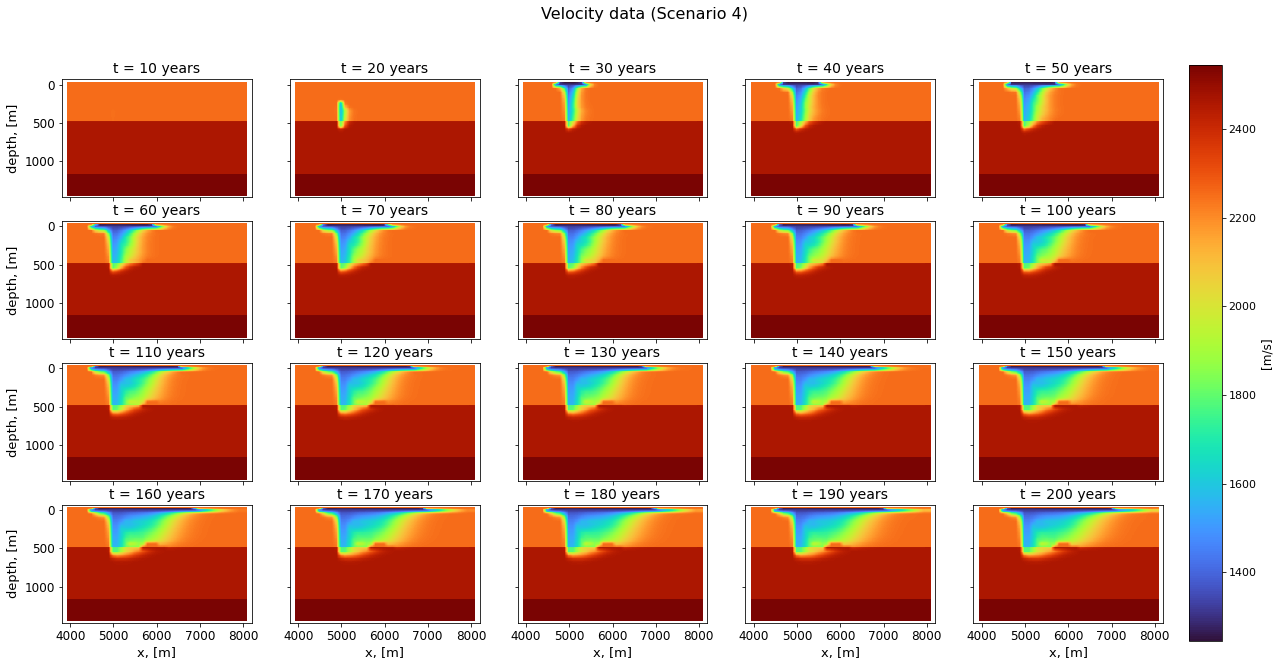

In [7]:
scen = 4 
plot_velocity(velocity[scen], scen)

#### Mid-depth plume example:

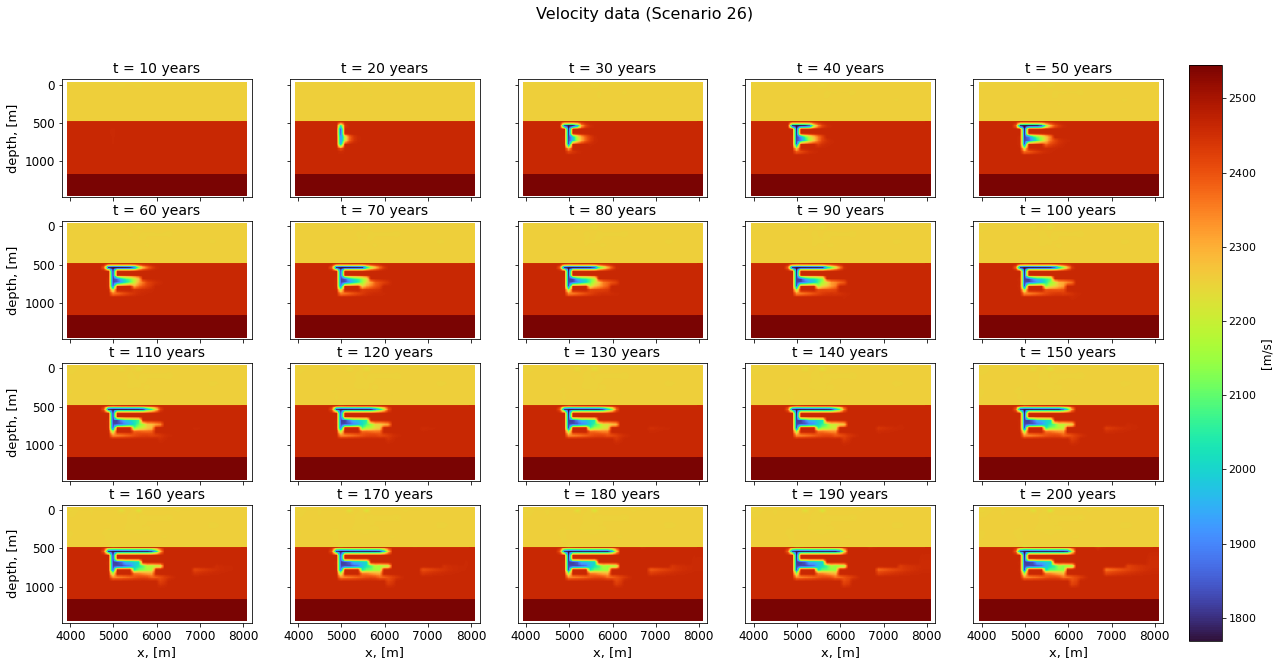

In [8]:
scen = 26
plot_velocity(velocity[scen], scen)

#### Deep plume example:

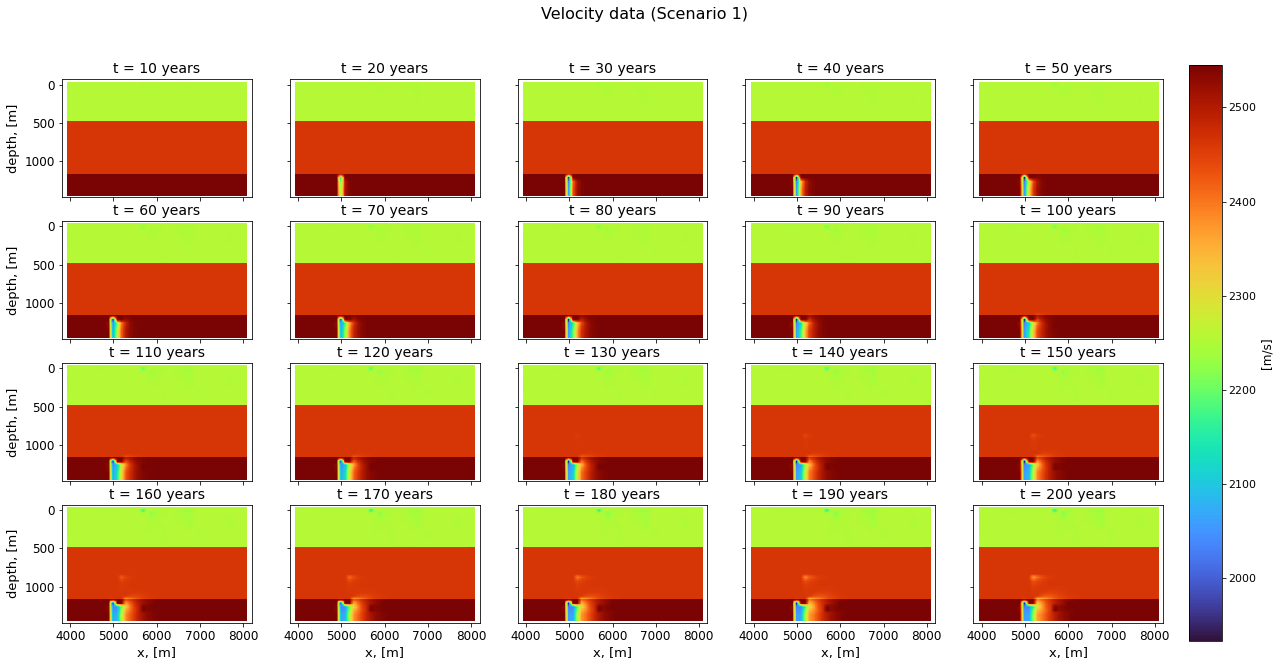

In [9]:
scen = 1
plot_velocity(velocity[scen], scen)

### 4. Input: Seismic data is loaded.

In [10]:
# Load seismic data
seismic_data_file = os.path.join(data_directory, 'seismic_optimization_data_5_scenarios.npz')
seismic = np.load(seismic_data_file)['data']
print('Seismic data shape:', seismic.shape)

Seismic data shape: (5, 20, 9, 101, 1251)


In [11]:
# Load seismic data difference
delta_seismic_data_file = os.path.join(data_directory, 'delta_seismic_optimization_data_5_scenarios.npz')
delta_seismic = np.load(delta_seismic_data_file)['data']
print('Difference in seismic data shape:', delta_seismic.shape)

Difference in seismic data shape: (5, 20, 9, 101, 1251)


In [12]:
# Define plotting function for seismic data
def plot_seismic(data, scen, source_ind, delta_seismic=False):
    x = np.linspace(0, 100, num=5)
    xlabels = 4+np.linspace(0, 4, num=5)
    y = np.linspace(0, 1200, num=5)
    ylabels = np.linspace(0, 2.5, num=5)
    time_indices = range(1, 20, 2)
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(18, 5),
                            sharex=True, sharey=True)
    # Cycle over time indices
    for ind, time_ind in enumerate(time_indices):
        row = ind//5
        col = ind%5
        ax_im = axs[row, col].imshow(data[scen][time_ind][source_ind-1, :, :].T,
                                     cmap='gray', aspect='auto')
        axs[row, col].set_title('t = {} years'.format((time_ind + 1)*10))

        # Add colorbar
        color_bar = fig.colorbar(ax_im, ax=axs[row, col], orientation='vertical')
        color_bar.ax.tick_params(axis='y', which='major', labelsize=8)

    for row in range(2):
        axs[row, 0].set_yticks(y, labels=ylabels)
        axs[row, 0].set_ylabel('Time, [sec]')
    for col in range(5):
        axs[1, col].set_xticks(x, labels=xlabels)
        axs[1, col].set_xlabel('Receiver location, [km]')

    if delta_seismic:
        fig.suptitle('Scenario {}: Seismic data difference (Source {})'.format(scen, source_ind))
    else:
        fig.suptitle('Scenario {}: Seismic data (Source {})'.format(scen, source_ind))

#### Seismic data for a selected scenario and source

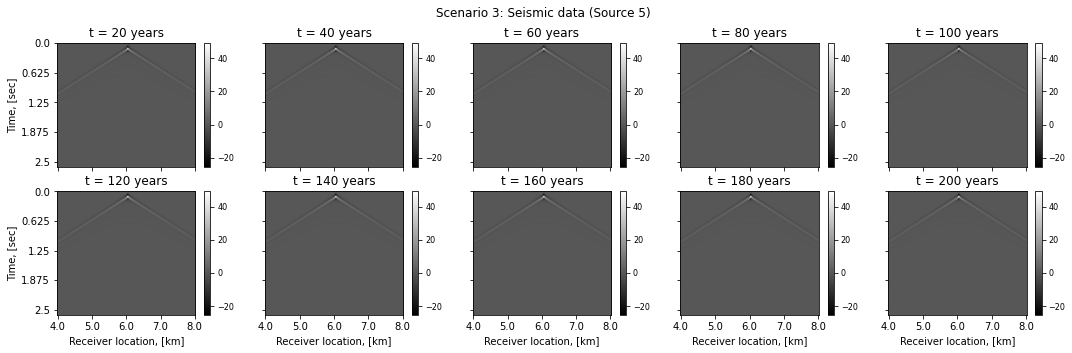

In [13]:
# Plot seismic data for a selected scenario
scen = 3
source_ind = 5
plot_seismic(seismic, scen, source_ind, delta_seismic=False)

#### Seismic data difference for a selected scenario and source

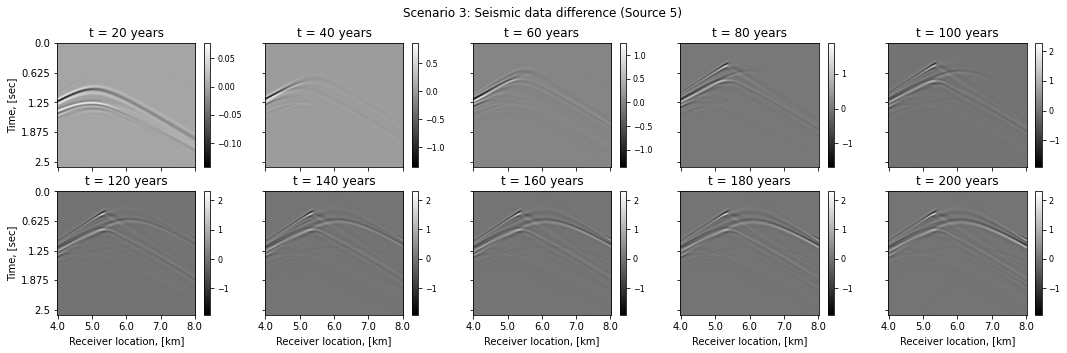

In [14]:
# Plot difference in seismic data for a selected scenario
scen = 3
source_ind = 5
plot_seismic(delta_seismic, scen, source_ind, delta_seismic=True)

### 5. Visualize possible predefined acquisition configurations.

In [15]:
# Load required classes and methods
sys.path.insert(0, os.sep.join(['..', '..', '..', 'source']))
from ramp.seismic_configuration import SeismicSurveyConfiguration
from ramp.seismic_configuration import five_n_receivers_array_creator

In [16]:
# Define coordinates of sources
num_sources = 9
sources = np.c_[4000 + np.array([240, 680, 1120, 1600, 2040, 2480, 2920, 3400, 3840]),
                np.zeros(num_sources),
                np.zeros(num_sources)]

# Define coordinates of receivers
num_receivers = 101
receivers = np.c_[4000 + np.linspace(0, 4000, num=num_receivers),
                  np.zeros(num_receivers),
                  np.zeros(num_receivers)]

In [17]:
# Create survey configuration with defined coordinates
array_creator_kwargs = {'source_coords': sources,
                        'receiver_coords': receivers}
configuration = SeismicSurveyConfiguration(
    sources, receivers, name='Survey', create_arrays=True,
    array_creator=five_n_receivers_array_creator,
    array_creator_kwargs=array_creator_kwargs)
# configuration.plot_configuration()

In [18]:
# Define plotting function for arrays
def plot_array(sources, receivers, configuration, ind=1, plot_all=False):

    fig = plt.figure(figsize=(13, 2))
    ax = fig.add_subplot(111)
    
    if not plot_all:
        sind = configuration.arrays[ind-1]['source']
        rind = configuration.arrays[ind-1]['receivers']
        nr = configuration.arrays[ind-1]['num_receivers'] # number of receivers in the array
        ax.plot([sources[sind, 0]], [0], 'or', label='source', markersize=6)
        ax.plot(receivers[rind, 0], nr*[0], 'sb', label='receivers', markersize=3)

        ax.annotate('{}'.format(sind+1), (sources[sind, 0], 0),
                    xytext=(-3, 5),  # 4 points vertical offset
                    textcoords='offset points', color='red')
        for rec_ind in range(nr):
            ax.annotate('{}'.format(rind[rec_ind]+1), (receivers[rind[rec_ind], 0], 0),
                    xytext=(-3, 5),  # 4 points vertical offset
                    textcoords='offset points', color='blue')
        ax.set_title('Location of source and receivers for array {}'.format(ind))
        
    else:
        ns = len(sources)
        nr = len(receivers)
        ax.plot(sources, ns*[0], 'or', label='sources', markersize=6)
        ax.plot(receivers, nr*[0], 'sb', label='receivers', markersize=3)
        ax.set_title('Location of sources and receivers for the whole survey')
        
    ax.set_xlim(4000, 8000)
    ax.set_xlabel('x, [m]')
    ax.set_yticks([0], labels=[0])
    ax.set_ylabel('depth, [m]')
    ax.legend()    

#### Dense array

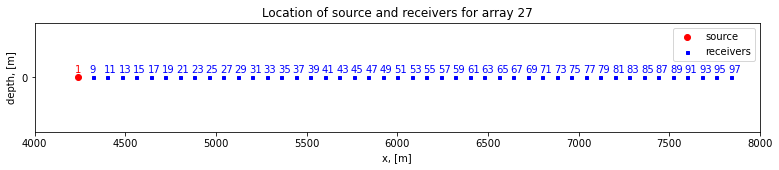

In [19]:
plot_array(sources, receivers, configuration, 27)

#### Sparse array

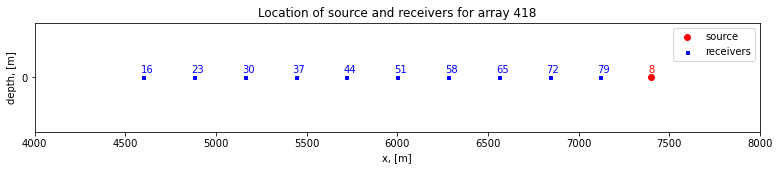

In [20]:
plot_array(sources, receivers, configuration, 418)

#### Complete seismic survey

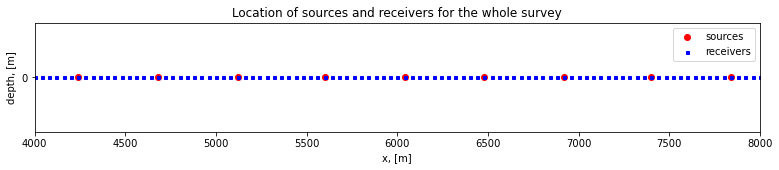

In [21]:
plot_array(sources[:, 0], receivers[:, 0], configuration, plot_all=True)

### 6. Examples of calculated parameter: NRMS 
NRMS is a normalized root-mean-square difference along the 2D seismic line. It is calculated as

\begin{align}
NRMS = \frac{200*\sqrt{\sum_{d_1}^{d^2}(trace_t - trace_{t_0})^2/N}}{\sqrt{\sum_{d_1}^{d^2}trace_t^2/N}+\sqrt{\sum_{d_1}^{d^2}trace_{t_0}^2/N}},
\end{align}

where $trace_t$ and $trace_{t_0}$ are the traces at time step $t$ and at the initial time step $t_0$; $d_1$ and $d_2$ are the start and end depths of the desired depth window; $N$ is the number of samples per trace within the desired window.

In [22]:
# Load nrms data
nrms_data_file = os.path.join(data_directory, 'nrms_optimization_data_300_scenarios.npz')
nrms = np.load(nrms_data_file)['data']
print('NRMS data shape', nrms.shape)

NRMS data shape (300, 20, 9, 101)


In [23]:
# Define plotting function for NRMS
def plot_nrms(nrms, scen):
    x = np.linspace(0, 100, num=11)
    xlabels = np.linspace(1, 101, num=11, dtype=int)
    y = np.linspace(0, 8, num=9)
    ylabels = np.linspace(1, 9, num=9, dtype=int)
    time_indices = range(1, 20, 2)
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 5),
                                sharex=True, sharey=True)
    # Cycle over time indices
    for ind, time_ind in enumerate(time_indices):
        row = ind//5
        col = ind%5
        ax_im = axs[row, col].imshow(nrms[scen][time_ind],
                                     cmap='viridis', aspect='auto')
        axs[row, col].set_title('t = {} years'.format((time_ind + 1)*10))

        # Add colorbar
        color_bar = fig.colorbar(ax_im, ax=axs[row, col], orientation='vertical')
        color_bar.ax.tick_params(axis='y', which='major', labelsize=8)

    # Set x-labels
    for col in range(5):
        axs[1, col].set_xticks(x, labels=xlabels)
        axs[1, col].set_xlabel('Receivers')

    # Set y-labels
    for row in range(2):
        axs[row, 0].set_yticks(y, labels=ylabels)
        axs[row, 0].set_ylabel('Sources')

    fig.suptitle('Scenario {}: NRMS'.format(scen))

#### NRMS data for a selected scenario

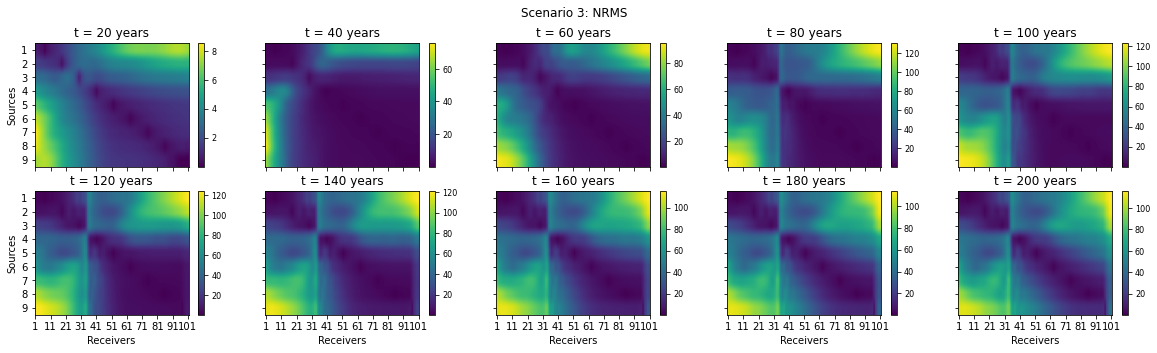

In [24]:
# Plot NRMS values
scen = 3
plot_nrms(nrms, scen)

### 7. Detectability as function of a threshold

In [25]:
# Obtain maximum NRMS values for all scenarios
max_nrms_values = {}
max_data_all = {}
for ind, tp in enumerate(time_points[1:]):
    max_data_all[tp] = nrms[:, ind+1, :, :]
    if ind != 0:
        max_nrms_values[tp] = np.max(max_data_all[tp], axis=(1, 2))  # maximum along sources and receivers axes
    else:
        max_nrms_values[tp] = np.max(nrms[:, ind+1, :, :], axis=(1, 2))

In [26]:
# Define NRMS threshold values
nrms_thresholds = [5, 10, 15]
print(nrms_thresholds)

[5, 10, 15]


In [27]:
# Determine how many of the leak scenarios will be detected with the full set of sources and receivers
detected_counts = {}
detected_prob = {}
undetected_leaks_scenarios = {}
for threshold in nrms_thresholds:
    detected_counts[threshold] = np.zeros(num_time_points)
    detected_prob[threshold] = np.zeros(num_time_points)
    for ind, tp in enumerate(time_points[1:]):  # starting with time point of 20 years
        detected_counts[threshold][ind+1] = len(np.where(max_nrms_values[tp] >= threshold)[0])
        #print(detected_counts[threshold][ind+1])
        detected_prob[threshold][ind+1] = 100*detected_counts[threshold][ind+1]/300

#### Percentage of leaks detected for the whole seismic survey as function of threshold

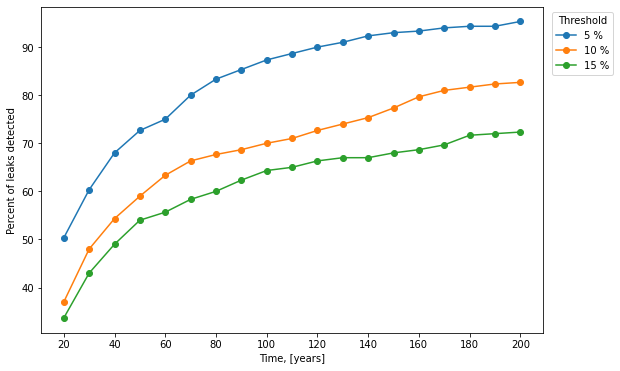

In [28]:
# Plot probability of detection based on threshold
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
for threshold in nrms_thresholds:
    axs.plot(time_points[1:], detected_prob[threshold][1:], '-o', label='{} %'.format(threshold))
axs.legend(ncol=1, title='Threshold', loc='upper right', bbox_to_anchor=(1.15, 1))
axs.set_xlabel('Time, [years]')
axs.set_ylabel('Percent of leaks detected')
axs.set_xticks(20*np.arange(10)+20);

#### Detectability of different arrays

In [29]:
# Load NRMS data for all the arrays
arrays_nrms_data_file = os.path.join(data_directory, 'arrays_nrms_data_3max_values_300_scenarios.npz')
arrays_nrms = np.load(arrays_nrms_data_file)['data']
print('Arrays NRMS data shape', arrays_nrms.shape) # num of arrays, num of scenarios, num of time points, num of max values

Arrays NRMS data shape (489, 300, 20, 3)


In [30]:
# Define plotting function for arrays detection probability
def plot_arrays_det_prob(array_inds, arrays_detected_prob):
    # Plot probability of detection for several arrays
    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(111)
    for array_ind in array_inds:
        ax.plot(time_points[1:], arrays_detected_prob[array_ind-1, 1:], '-o', label='array {}'.format(array_ind))
    ax.legend(ncol=1, title='Arrays', loc='upper right', bbox_to_anchor=(1.15, 1))
    ax.set_xlabel('Time, [years]')
    ax.set_ylabel('Percent of leaks detected')
    ax.set_ylim(-1, 100)
    ax.set_xticks(20*np.arange(10)+20);

In [31]:
from ipywidgets import interact, IntSlider, HBox, IntText, BoundedIntText
import ipywidgets as widgets

In [32]:
# Define function calculating the probability of detection for all arrays in response to change of threshold
def interactive_plot_arrays_detection_probability(nrms_threshold):
    # Check how many scenarios and time points have NRMS larger than the threshold
    zeros_ones_arrays = np.zeros(arrays_nrms.shape)
    zeros_ones_arrays[arrays_nrms >= nrms_threshold] = 1
    # Calculate probability of detection for each array developing in time
    arrays_detected_prob = np.zeros((configuration.num_arrays, num_time_points))
    for array_ind in configuration.arrays:
        arrays_detected_prob[array_ind] = 100*np.sum(zeros_ones_arrays[array_ind, :, :, 2], axis=0)/num_scenarios
    array_inds = list(range(1, 11))
    plot_arrays_det_prob(array_inds, arrays_detected_prob)

#### INTERACTIVE PLOT: Percent of leak detected for different arrays as a function of threshold

In [33]:
style = {'description_width': 'initial'}
interactive_plot1 = interact(interactive_plot_arrays_detection_probability, 
                             nrms_threshold=IntSlider(description='NRMS threshold, [%]', value=5, min=1, max=30, step=1,
                                                      continuous_update=False, style=style))
interactive_plot1;

interactive(children=(IntSlider(value=5, continuous_update=False, description='NRMS threshold, [%]', max=30, m…

In [34]:
# Define function calculating the probability of detection for all arrays in response to change of threshold
def interactive_plot_arrays_detection_probability2(nrms_threshold, array_inds):
    # Check how many scenarios and time points have NRMS larger than the threshold
    zeros_ones_arrays = np.zeros(arrays_nrms.shape)
    zeros_ones_arrays[arrays_nrms >= nrms_threshold] = 1
    # Calculate probability of detection for each array developing in time
    arrays_detected_prob = np.zeros((configuration.num_arrays, num_time_points))
    for array_ind in configuration.arrays:
        arrays_detected_prob[array_ind] = 100*np.sum(zeros_ones_arrays[array_ind, :, :, 2], axis=0)/num_scenarios
    array_inds=[array_inds]
    plot_arrays_det_prob(array_inds, arrays_detected_prob)

#### INTERACTIVE PLOT: Percent of leak detected as a function of threshold and array index

In [35]:
style = {'description_width': 'initial'}
nrms_threshold_slider=IntSlider(description='NRMS threshold, [%]', 
                         value=5, min=1, max=30, step=1,
                         continuous_update=False, style=style)
array_inds_slider=IntSlider(description='Array index', value=126, min=1, max=489, step=1, continuous_update=False, style=style)
#array_inds = BoundedIntText(value=1, min=1, max=489, step=1, description='Array index', disabled=False)
ui = HBox([nrms_threshold_slider, array_inds_slider])

out = widgets.interactive_output(interactive_plot_arrays_detection_probability2, 
                                 {'nrms_threshold': nrms_threshold_slider, 
                                  'array_inds': array_inds_slider})

display(ui, out)

Output()

In [36]:
# Determine which of the scenarios are detected and at what time by one of the arrays
nrms_threshold = 5
zeros_ones_arrays = np.zeros(arrays_nrms.shape)
zeros_ones_arrays[arrays_nrms >= nrms_threshold] = 1
print(zeros_ones_arrays.shape)
scenarios_detected = np.sum(zeros_ones_arrays, axis=0)[:, :, 0]
arrays_detecting = np.sum(zeros_ones_arrays, axis=1)[:, :, 0]

(489, 300, 20, 3)


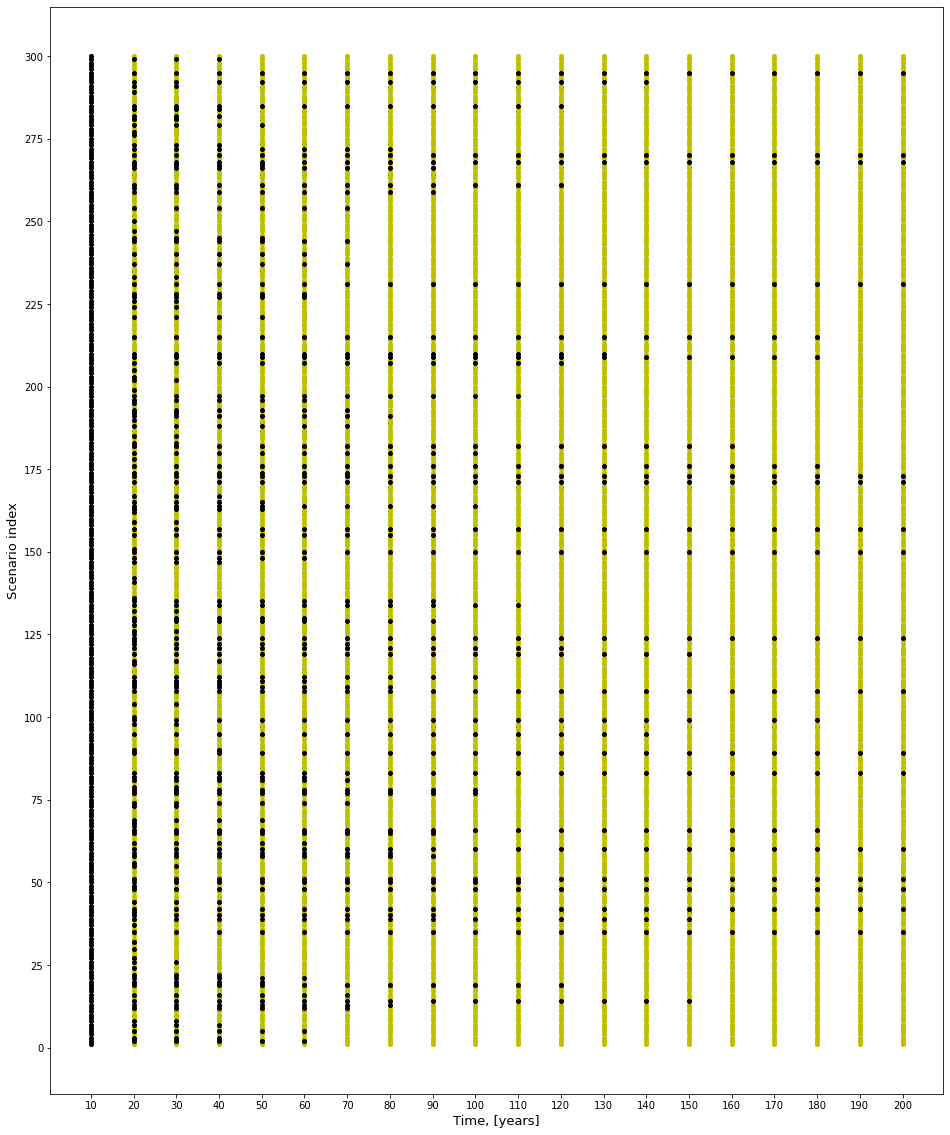

In [37]:
# Plot results of calculations
labelsize = 12
fig = plt.figure(figsize=(16, 20))
ax = fig.add_subplot(111)
for t_ind, tp in enumerate(time_points):
    detect = np.where(scenarios_detected[:, t_ind] > 0)[0]+1
    num_detect = len(detect)
    not_detect = np.where(scenarios_detected[:, t_ind] == 0)[0]+1
    num_not_detect = len(not_detect)
    
    if num_detect > 0:
        ax.plot(num_detect*[tp], detect, 'yo', markersize=4)
    if num_not_detect > 0:
        ax.plot(num_not_detect*[tp], not_detect, 'ko', markersize=4)
ax.set_xlabel('Time, [years]', fontsize=labelsize+1)
ax.set_xticks(np.linspace(10, 200, 20))
ax.set_ylabel('Scenario index', fontsize=labelsize+1)
ax.set_yticks(np.linspace(0, 300, 13));

In [38]:
not_detect

array([ 35,  42,  48,  51,  60,  83,  89, 108, 124, 150, 157, 171, 173,
       231, 268, 270, 295], dtype=int64)

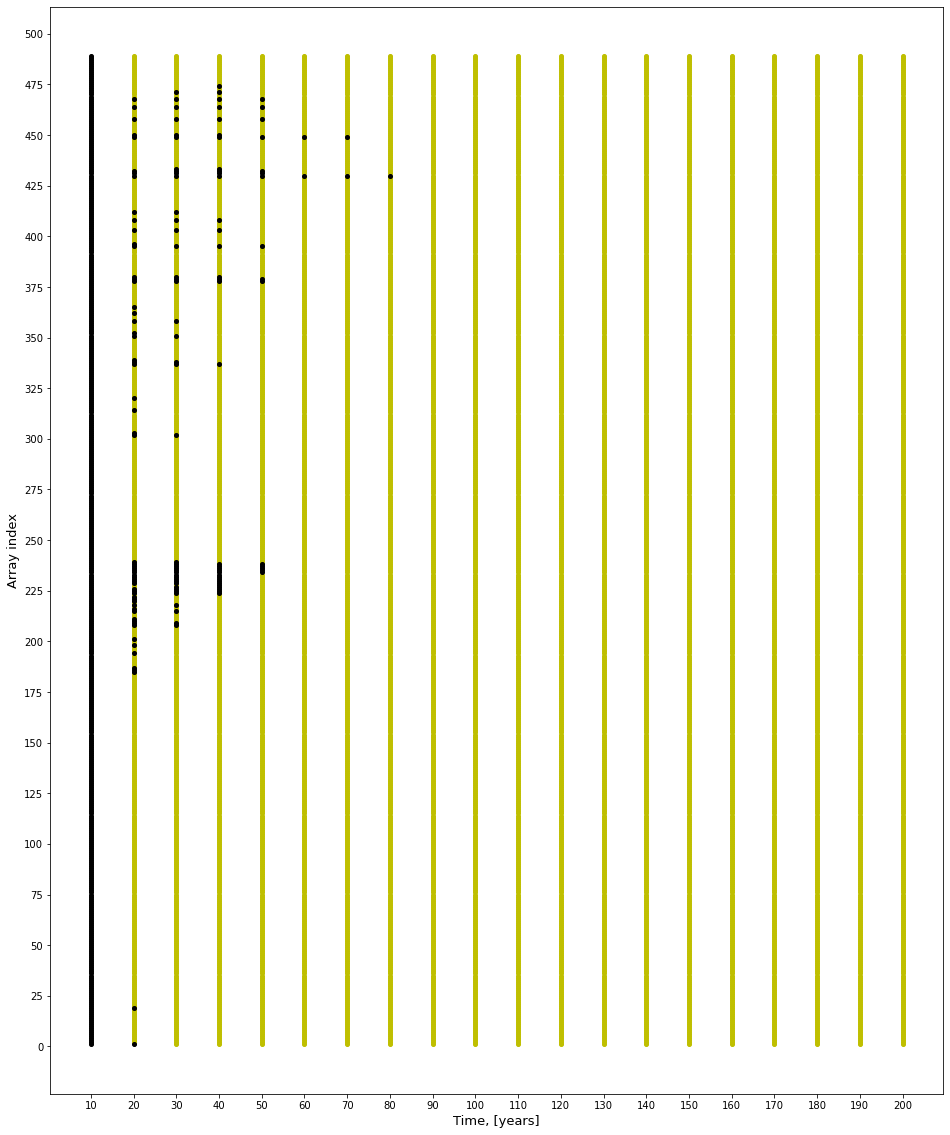

In [39]:
# Plot results of calculations
labelsize = 12
fig = plt.figure(figsize=(16, 20))
ax = fig.add_subplot(111)
for t_ind, tp in enumerate(time_points):
    detect = np.where(arrays_detecting[:, t_ind] > 0)[0]+1
    num_detect = len(detect)
    not_detect = np.where(arrays_detecting[:, t_ind] == 0)[0]+1
    num_not_detect = len(not_detect)
    
    if num_detect > 0:
        ax.plot(num_detect*[tp], detect, 'yo', markersize=4)
    if num_not_detect > 0:
        ax.plot(num_not_detect*[tp], not_detect, 'ko', markersize=4)
ax.set_xlabel('Time, [years]', fontsize=labelsize+1)
ax.set_xticks(np.linspace(10, 200, 20))
ax.set_ylabel('Array index', fontsize=labelsize+1)
ax.set_yticks(np.linspace(0, 500, 21));

### 7. Optimization

In [40]:
from ramp.ttd_det_optimization import *

In [41]:
nrms_threshold = 5
zeros_ones_arrays = np.zeros(arrays_nrms.shape)
zeros_ones_arrays[arrays_nrms >= nrms_threshold] = 1

In [42]:
# Determine the best possible case with all the arrays used
num_scen_det_best = 0  # maximum number 
ttd_best = []  # list of TTFD for each scenarios
for scen_ind in range(num_scenarios):
    # Determines whether at least one array for at least one time point detected a leak for a given scenario
    if np.any(zeros_ones_arrays[:, scen_ind, :, 0]):  # 0 corresponds to the 3rd largest NRMS values
        num_scen_det_best += 1 # calculates the maximum number of scenarios that can be determined by at least one array
    # Determines whether there is at one array for at least one time point detected a leak for a given scenario
    if len(np.where(np.any(zeros_ones_arrays[:, scen_ind, :, 0], axis=0))[0]) > 0:
        ttd_best += [np.min(np.where(np.any(zeros_ones_arrays[:, scen_ind, :, 0], axis=0))[0])+1]
    else:
        ttd_best += [np.inf]
        
ttd_best = np.array(ttd_best)

In [43]:
print(np.where(ttd_best==np.inf)[0])

[ 34  41  47  50  59  82  88 107 123 149 156 170 172 230 267 269 294]


#### (a) Monitoring is done at a single point in time

In [44]:
plans1 = single_array_timings(zeros_ones_arrays[:, :, :, 0])
plans1up = find_unique_pareto(plans1)

x1 = np.array([plan[1] for plan in plans1])
y1 = np.array([plan[2] for plan in plans1])
r1 = pareto(x1, y1)

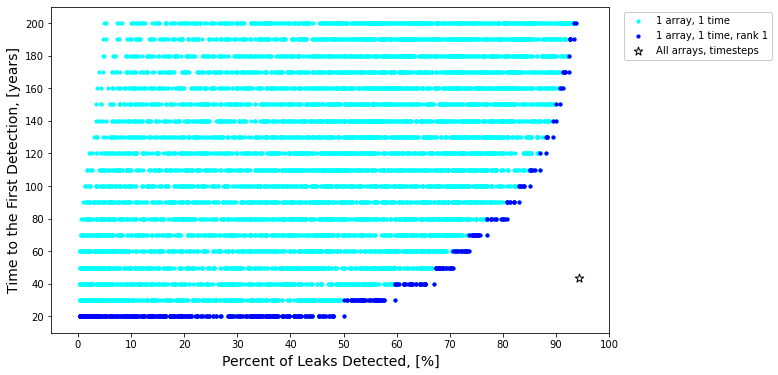

In [45]:
yticks_labels = np.linspace(20, 200, num=10, dtype=int)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(100*x1/num_scenarios, 10*(y1+1), s=10, c='cyan', label='1 array, 1 time')
ax.scatter(100*x1[r1==1]/num_scenarios, 10*(y1[r1==1]+1), s=10, c='blue', label='1 array, 1 time, rank 1')
ax.scatter(100*num_scen_det_best/num_scenarios, 10*np.mean(ttd_best[ttd_best!=np.inf]), s=80, marker='*', ec='black',
            fc='white', zorder=5, label='All arrays, timesteps')
ax.set_xlim((-5, 100))
ax.set_ylim((10, 210))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_yticks(yticks_labels)
ax.set_xticks(np.linspace(0, 100, 11))
ax.set_xlabel('Percent of Leaks Detected, [%]', fontsize=14)
ax.set_ylabel('Time to the First Detection, [years]', fontsize=14)
ax.legend(framealpha=1.0, loc='upper right', bbox_to_anchor=(1.3, 1));

#### Assume user wants to detect the maximum number of leaks as soon as they start monitoring: 20 years; another option is to wait another 10 years and detect 9-10 % more; or another 20 years and another 27-28%.

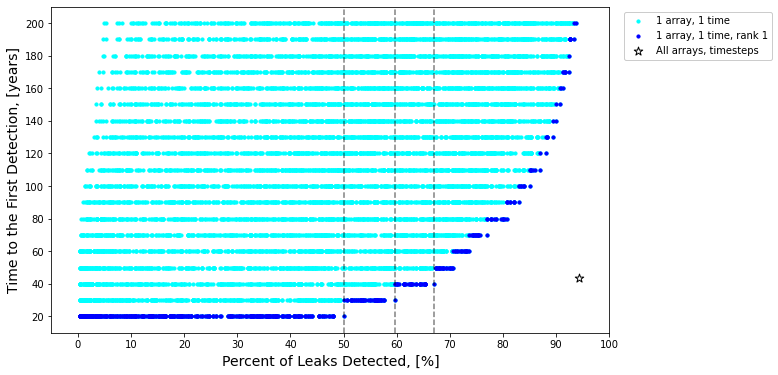

In [46]:
yticks_labels = np.linspace(20, 200, num=10, dtype=int)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(100*x1/num_scenarios, 10*(y1+1), s=10, c='cyan', label='1 array, 1 time')
ax.scatter(100*x1[r1==1]/num_scenarios, 10*(y1[r1==1]+1), s=10, c='blue', label='1 array, 1 time, rank 1')
ax.scatter(100*num_scen_det_best/num_scenarios, 10*np.mean(ttd_best[ttd_best!=np.inf]), s=80, marker='*', ec='black',
            fc='white', zorder=5, label='All arrays, timesteps')
ax.plot([50, 50], [10, 210], '--k', alpha=0.5)
ax.plot([59.6, 59.6], [10, 210], '--k', alpha=0.5)
ax.plot([67, 67], [10, 210], '--k', alpha=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yticks(yticks_labels)
ax.set_xticks(np.linspace(0, 100, 11))
ax.set_xlabel('Percent of Leaks Detected, [%]', fontsize=14)
ax.set_ylabel('Time to the First Detection, [years]', fontsize=14)
ax.legend(framealpha=1.0, loc='upper right', bbox_to_anchor=(1.3, 1));

In [47]:
# Find indices of chosen plans consisting of one array and one time point 
best_arrays_indices = []
for time_ind in range(1, 4):
    ind = np.where(np.logical_and(y1==time_ind, x1==np.max(x1[y1==time_ind])))[0]
    best_arrays_indices.append(ind[0])

In [48]:
best_arrays_indices

[4363, 447, 3789]

In [49]:
# Visualize configuration for each selected array
list_plans1 = list(plans1)

In [50]:
for ind in best_arrays_indices:
    print(list_plans1[ind]) # the same array produces the best detection

(((393, 1),), 150.0, 1)
(((393, 2),), 179.0, 2)
(((393, 3),), 201.0, 3)


In [51]:
ind = best_arrays_indices[0]
print(ind)
# Get array corresponding to the first plan
array_ind = list_plans1[ind][0][0][0]
print(array_ind)
sind = configuration.arrays[array_ind]['source']
rind = configuration.arrays[array_ind]['receivers']
print(sind, rind)

4363
393
7 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]


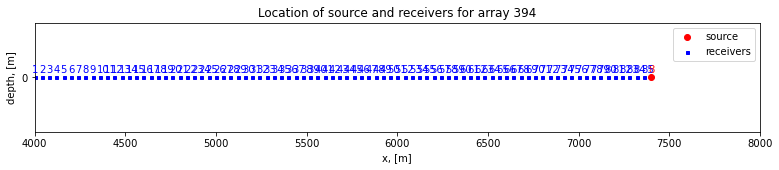

In [52]:
# Visualize selected array
plot_array(sources, receivers, configuration, array_ind+1)

In [53]:
style = {'description_width': 'initial'}
nrms_threshold_slider=IntSlider(description='NRMS threshold, [%]', 
                         value=5, min=1, max=30, step=1,
                         continuous_update=False, style=style)
array_inds_slider=IntSlider(description='Array index', value=394, min=1, max=489, step=1, continuous_update=False, style=style)
#array_inds = BoundedIntText(value=1, min=1, max=489, step=1, description='Array index', disabled=False)
ui = HBox([nrms_threshold_slider, array_inds_slider])

out = widgets.interactive_output(interactive_plot_arrays_detection_probability2, 
                                 {'nrms_threshold': nrms_threshold_slider, 
                                  'array_inds': array_inds_slider})

display(ui, out)

Output()